In [1]:
%pip install requests
%pip install numpy 
%pip install pandas 
%pip install matplotlib 
%pip install yfinance 
%pip install scikit-learn 
%pip install tensorflow 
%pip install seaborn
%pip install os
print("Installation abgeschlossen")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Installation abgeschlossen


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Daten für PLUG geladen:
Kopfzeile:
Price      Close  High   Low  Open   Volume
Ticker      PLUG  PLUG  PLUG  PLUG     PLUG
Date                                       
2018-01-02  2.42  2.44  2.32  2.38  2845600
2018-01-03  2.42  2.44  2.38  2.40  2331100
2018-01-04  2.40  2.42  2.36  2.40  2458000
2018-01-05  2.36  2.43  2.33  2.43  3217600
2018-01-08  2.33  2.38  2.30  2.35  3720700
Fußzeile:
Price      Close  High   Low  Open    Volume
Ticker      PLUG  PLUG  PLUG  PLUG      PLUG
Date                                        
2024-12-23  2.43  2.64  2.39  2.55  46539800
2024-12-24  2.42  2.46  2.31  2.45  31547700
2024-12-26  2.38  2.43  2.33  2.39  53837400
2024-12-27  2.38  2.52  2.28  2.36  61228200
2024-12-30  2.28  2.35  2.21  2.32  39360300

Berechnete Indikatoren:
Price      Close  High   Low  Open    Volume bb_basis  bb_stdev  bb_upper  \
Ticker      PLUG  PLUG  PLUG  PLUG      PLUG                                
Date                                                            

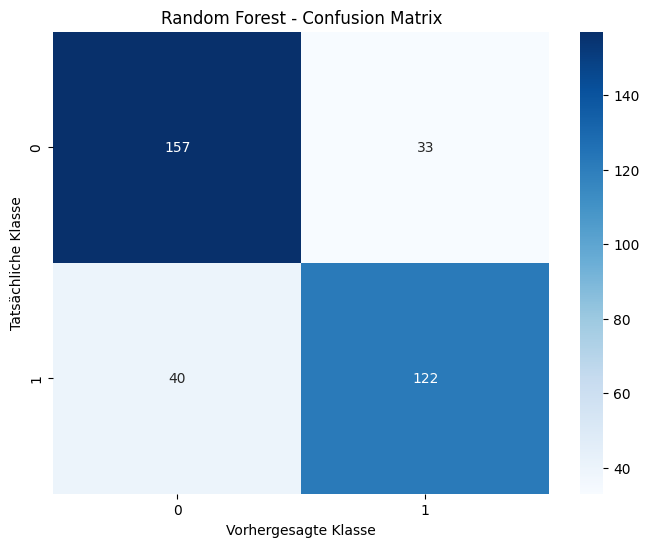

Vorbereitung von LSTM-Daten mit 10-Zeitschritten

LSTM Modell-Architektur:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        19,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,651 (154.89 KB)

 Trainable params: 39,651 (154.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5335 - loss: 0.6885 - val_accuracy: 0.5071 - val_loss: 0.7000
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6475 - loss: 0.6511 - val_accuracy: 0.4857 - val_loss: 0.7320
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6571 - loss: 0.6188 - val_accuracy: 0.4429 - val_loss: 0.7359
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6838 - loss: 0.6055 - val_accuracy: 0.5107 - val_loss: 0.7571
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7250 - loss: 0.5685 - val_accuracy: 0.4429 - val_loss: 0.7706
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7497 - loss: 0.5265 - val_accuracy: 0.4393 - val_loss: 0.8952
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7684 - loss: 0.5132 - val_accuracy: 0.4107 - val_loss: 0.9720
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7392 - loss: 0.5175 - val_accuracy: 0.4464 - v

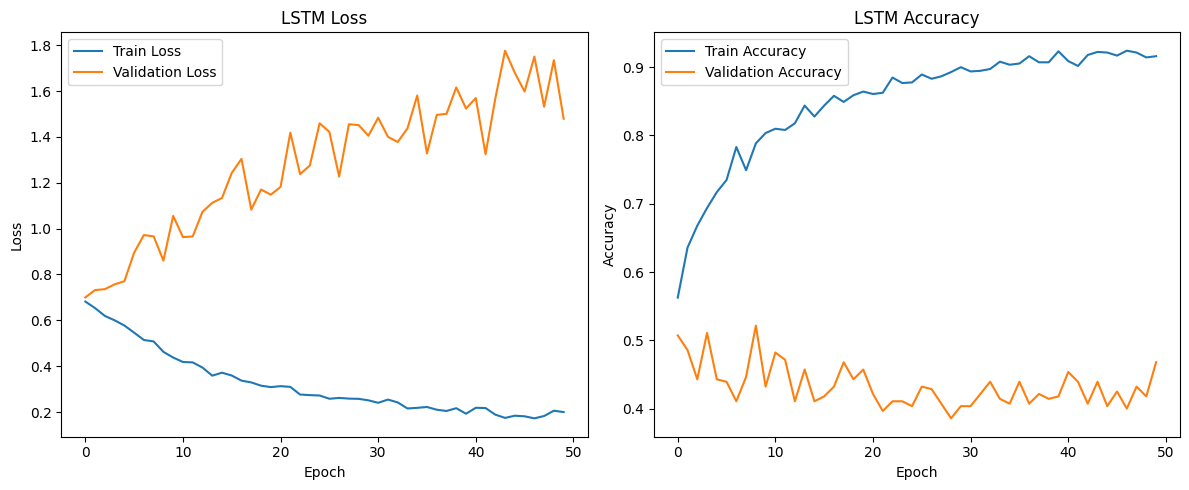

[*********************100%***********************]  1 of 1 completed


Fehler beim Erstellen der Basis-Features: Cannot set a DataFrame with multiple columns to the single column price_vs_sma
Fehler beim Erstellen der Basis-Features: Cannot set a DataFrame with multiple columns to the single column price_vs_sma
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Erzeugte Handelssignale:
                 Date  Close  RF_Signal  LSTM_Signal  Combined_Signal  \
Date                                                                    
2024-12-23 2024-12-23   2.43          0            0                0   
2024-12-24 2024-12-24   2.42          0            0                0   
2024-12-26 2024-12-26   2.38          0            0                0   
2024-12-27 2024-12-27   2.38          0            0                0   
2024-12-30 2024-12-30   2.28          0            0                0   

            Pine_Signal  
Date                     
2024-12-23            0  
2024-12-24            0  
2024-12-26            0  
2024-12-27            0  
2024-12-30            0  

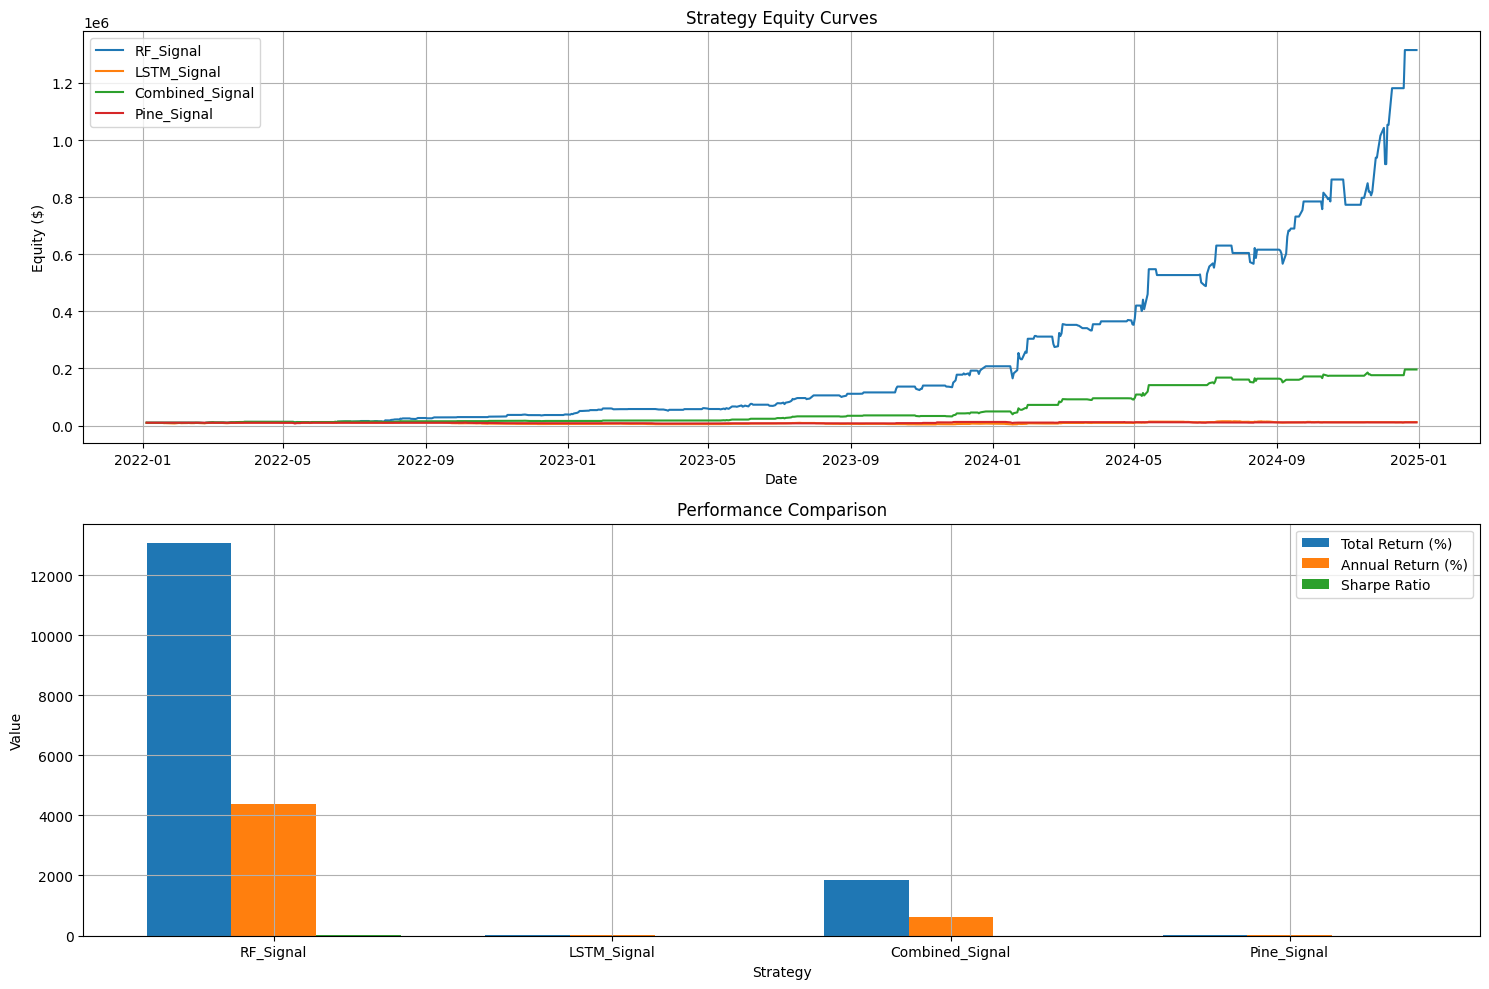

[*********************100%***********************]  1 of 1 completed


Backtest Ergebnisse:
                      RF_Signal  LSTM_Signal  Combined_Signal  Pine_Signal
Total Return (%)   13053.015507    21.063223      1864.210892    11.802148
Annual Return (%)   4362.958480     7.040363       623.110784     3.944857
Max Drawdown (%)     -20.394733   -65.575604       -20.394733   -31.394422
Sharpe Ratio           3.012750     0.412840         2.292658     0.272211
Fehler beim Erstellen der Basis-Features: Cannot set a DataFrame with multiple columns to the single column price_vs_sma


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

Aktuelle Vorhersagen für PLUG:
Datum: 2025-03-13
Fehler bei der LSTM-Vorhersage: unsupported format string passed to Series.__format__
Nur Random Forest Vorhersage verfügbar:
Random Forest Wahrscheinlichkeit für Aufwärtstrend: 45.00%
Signal (nur RF): HALTEN
Die Handelssignale wurden in handelssignale.csv exportiert.
Datei PLUG_stock_data_1.json erstellt: 9.99 KB mit 179 Datenpunkten
Datei PLUG_stock_data_2.json erstellt: 9.99 KB mit 178 Datenpunkten
Datei PLUG_stock_data_3.json erstellt: 0.50 KB mit 9 Datenpunkten

Insgesamt wurden 3 Dateien erstellt, die alle 366 Datenpunkte enthalten.


3

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from datetime import datetime
import warnings
import time
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os
warnings.filterwarnings('ignore')

# Globaler Epsilon-Wert zur Vermeidung von Division durch 0
EPSILON = 1e-10
# Hier den Oracle APEX REST-Endpoint angeben:
apex_url = 'https://apex.oracle.com/pls/apex/stratify/stocks/stocks'
# 1. Daten herunterladen
def download_data(symbol, start_date, end_date, interval='1d'):
    """Lädt Daten von Yahoo Finance herunter"""
    data = yf.download(symbol, start=start_date, end=end_date, interval=interval)
    return data

# Beispiel: Ticker und Zeitraum anpassen
symbol = 'PLUG'
start_date = '2018-01-01'
end_date = '2024-12-31'
data = download_data(symbol, start_date, end_date)

print(f"Daten für {symbol} geladen:")
print("Kopfzeile:")
print(data.head())
print("Fußzeile:")
print(data.tail())

# 2. Indikatoren berechnen
def calculate_indicators(df):
    """Berechnet die Indikatoren aus deinem Pine-Code"""
    df = df.copy()

    # Bollinger Bands
    bb_length = 20
    bb_mult = 2.0
    df['bb_basis'] = df['Close'].rolling(window=bb_length).mean()
    df['bb_stdev'] = df['Close'].rolling(window=bb_length).std()
    df['bb_upper'] = df['bb_basis'] + bb_mult * df['bb_stdev']
    df['bb_lower'] = df['bb_basis'] - bb_mult * df['bb_stdev']

    # RSI mit Epsilon zur Vermeidung von Division durch 0
    rsi_length = 14
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=rsi_length).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=rsi_length).mean()
    rs = gain / (loss + EPSILON)
    df['rsi'] = 100 - (100 / (1 + rs))

    # SMA und EMA
    sma_length = 50
    df['sma'] = df['Close'].rolling(window=sma_length).mean()
    ema_length = 50
    df['ema'] = df['Close'].ewm(span=ema_length, adjust=False).mean()

    # ADX-Berechnungen
    adx_length = 14
    # Sicherstellen, dass High, Low und Close 1D-Arrays sind:
    high_values = np.array(df['High'].values).flatten()
    low_values = np.array(df['Low'].values).flatten()
    close_values = np.array(df['Close'].values).flatten()
    close_shifted = np.array(df['Close'].shift().values).flatten()

    # Berechnung der True-Range-Komponenten
    tr1 = np.abs(high_values - low_values)
    tr2 = np.abs(high_values - close_shifted)
    tr3 = np.abs(low_values - close_shifted)

    tr_df = pd.DataFrame({
        'tr1': pd.Series(tr1, index=df.index),
        'tr2': pd.Series(tr2, index=df.index),
        'tr3': pd.Series(tr3, index=df.index)
    })
    tr = tr_df.max(axis=1)
    atr = tr.rolling(window=adx_length).mean()

    # Directional Movement
    high_diff = np.diff(high_values, prepend=high_values[0])
    low_diff = np.diff(low_values, prepend=low_values[0])
    plus_dm = pd.Series(high_diff, index=df.index)
    minus_dm = pd.Series(low_diff, index=df.index)
    
    plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
    minus_dm = minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)

    plus_di = 100 * (plus_dm.rolling(window=adx_length).mean() / (atr + EPSILON))
    minus_di = 100 * (minus_dm.rolling(window=adx_length).mean() / (atr + EPSILON))

    sum_di = plus_di + minus_di
    sum_di_safe = sum_di.replace(0, np.nan)
    dx = 100 * abs(plus_di - minus_di) / (sum_di_safe + EPSILON)

    df['adx'] = dx.rolling(window=adx_length).mean().fillna(0)
    df['di_plus'] = plus_di.fillna(0)
    df['di_minus'] = minus_di.fillna(0)

    # MACD
    macd_fast = 12
    macd_slow = 26
    macd_signal = 9
    df['macd_fast'] = df['Close'].ewm(span=macd_fast, adjust=False).mean()
    df['macd_slow'] = df['Close'].ewm(span=macd_slow, adjust=False).mean()
    df['macd_line'] = df['macd_fast'] - df['macd_slow']
    df['macd_signal'] = df['macd_line'].ewm(span=macd_signal, adjust=False).mean()
    df['macd_histogram'] = df['macd_line'] - df['macd_signal']

    # Stochastic RSI
    stoch_length = 14
    df['stoch_k'] = ((df['Close'] - df['Low'].rolling(window=stoch_length).min()) /
                     (df['High'].rolling(window=stoch_length).max() - df['Low'].rolling(window=stoch_length).min() + EPSILON)) * 100
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()

    # Entry- und Exit-Conditions
    df['long_condition'] = ((df['stoch_k'] > 80) | (df['stoch_k'] < 20)) & (df['rsi'] < 30) & (df['adx'] > 25)
    df['exit_condition'] = (df['rsi'] > 50) & (df['rsi'].shift(1) <= 50)

    # Target: 1 für Kauf, -1 für Verkauf, 0 für Halten
    df['target'] = 0
    df.loc[df['long_condition'], 'target'] = 1
    df.loc[df['exit_condition'], 'target'] = -1

    df = df.fillna(0)
    return df

data_with_indicators = calculate_indicators(data)
print("\nBerechnete Indikatoren:")
print(data_with_indicators.tail())

# 3. Feature Engineering
def create_features(df):
    """Erstellt Features für die ML-Modelle"""
    features = df.copy()
    
    # Sicherstellen, dass relevante Spalten als Series vorliegen
    for col in ['Close', 'sma', 'ema', 'bb_basis', 'bb_upper', 'bb_lower']:
        if isinstance(features[col], pd.DataFrame):
            features[col] = features[col].squeeze()
    
    try:
        features['bb_basis'] = features['bb_basis'].replace(0, np.nan)
        # Explizit squeeze() verwenden, um sicherzustellen, dass das Ergebnis 1D ist
        features['price_vs_sma'] = (features['Close'] / (features['sma'] + EPSILON) - 1).squeeze()
        
        features['ema'] = features['ema'].replace(0, np.nan)
        features['price_vs_ema'] = (features['Close'] / (features['ema'] + EPSILON) - 1).squeeze()
        
        features['volume_change'] = features['Volume'].pct_change()
        features['close_change'] = features['Close'].pct_change()
    except Exception as e:
        print(f"Fehler beim Erstellen der Basis-Features: {e}")
    
    # Lag-Features für zeitliche Abhängigkeiten
    for col in ['rsi', 'adx', 'macd_line', 'stoch_k']:
        if col in features.columns:
            for lag in [1, 3, 5]:
                features[f'{col}_lag_{lag}'] = features[col].shift(lag)

    # Moving Average von Features
    for col in ['rsi', 'adx', 'macd_line', 'stoch_k']:
        if col in features.columns:
            for window in [3, 5]:
                features[f'{col}_ma_{window}'] = features[col].rolling(window=window).mean()

    # Verhältnis-Features
    try:
        if isinstance(features['adx'], pd.Series):
            adx_series = features['adx'].replace(0, np.nan)
            features['adx'] = adx_series
            if isinstance(features['rsi'], pd.Series):
                features['rsi_vs_adx'] = features['rsi'] / (adx_series + EPSILON)
        
        if isinstance(features['rsi'], pd.Series):
            rsi_series = features['rsi'].replace(0, np.nan)
            features['rsi'] = rsi_series
            if isinstance(features['stoch_k'], pd.Series):
                features['stoch_k_vs_rsi'] = features['stoch_k'] / (rsi_series + EPSILON)
    except Exception as e:
        print(f"Fehler beim Erstellen der Verhältnis-Features: {e}")

    # Future Return und Direction
    n_days = 5
    features['future_return'] = features['Close'].shift(-n_days) / features['Close'] - 1
    features['future_direction'] = (features['future_return'] > 0).astype(int)

    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.fillna(0)
    
    for col in features.columns:
        if features[col].dtype in [np.float64, np.float32]:
            max_val = 1e6
            features[col] = features[col].clip(-max_val, max_val)

    return features

features_df = create_features(data_with_indicators)
print("\nErstellte Features:")
print(features_df.tail())

# 4. Machine Learning Modelle

# 4.1 Random Forest
def train_random_forest(features, target_col='future_direction'):
    X = features.drop(['future_return', 'future_direction', 'target'], axis=1)
    y = features[target_col]
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(0, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    y_pred = rf.predict(X_test_scaled)
    print("\nRandom Forest Modell Performance:")
    print(classification_report(y_test, y_pred))
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    print("\nTop 10 wichtigste Features:")
    print(feature_importance.head(10))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest - Confusion Matrix')
    plt.ylabel('Tatsächliche Klasse')
    plt.xlabel('Vorhergesagte Klasse')
    plt.show()
    return rf, scaler, X.columns

rf_model, rf_scaler, feature_names = train_random_forest(features_df)

# 4.2 LSTM-Modell
def prepare_lstm_data(features, lookback=10, target_col='future_direction'):
    X = features.drop(['future_return', 'future_direction', 'target'], axis=1).values
    y = features[target_col].values
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    max_allowed = 1e6
    X = np.clip(X, -max_allowed, max_allowed)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_lstm, y_lstm = [], []
    for i in range(lookback, len(X_scaled)):
        X_lstm.append(X_scaled[i-lookback:i])
        y_lstm.append(y[i])
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
    split_idx = int(len(X_lstm) * 0.8)
    X_train, X_test = X_lstm[:split_idx], X_lstm[split_idx:]
    y_train, y_test = y_lstm[:split_idx], y_lstm[split_idx:]
    return X_train, X_test, y_train, y_test, scaler

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lookback = 10
print(f"Vorbereitung von LSTM-Daten mit {lookback}-Zeitschritten")
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, lstm_scaler = prepare_lstm_data(features_df, lookback=lookback)
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
lstm_model = create_lstm_model(input_shape)
print("\nLSTM Modell-Architektur:")
lstm_model.summary()
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm_classes = (y_pred_lstm > 0.5).astype(int).reshape(-1)
lstm_eval = lstm_model.evaluate(X_test_lstm, y_test_lstm)
print(f"\nLSTM Test Loss: {lstm_eval[0]:.4f}, Accuracy: {lstm_eval[1]:.4f}")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# 5. Handelssignale generieren
def generate_trading_signals(df, rf_model, rf_scaler, feature_names, lstm_model, lstm_scaler, lookback=10):
    """Generiert Handelssignale basierend auf ML-Modellen"""
    df_processed = df.copy()
    if 'rsi' not in df_processed.columns:
        df_processed = calculate_indicators(df_processed)
    if 'price_vs_sma' not in df_processed.columns:
        df_processed = create_features(df_processed)
    
    # Sicherstellen, dass 'Close' und 'long_condition' als eindimensionale Series vorliegen
    close_series = df_processed['Close'].squeeze()
    pine_signals = df_processed['long_condition'].astype(int).squeeze()
    
    features = df_processed[feature_names].copy()
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.fillna(0, inplace=True)
    features_scaled = rf_scaler.transform(features)
    rf_probs = rf_model.predict_proba(features_scaled)[:, 1]
    rf_signals = (rf_probs > 0.6).astype(int).flatten()
    
    # LSTM-Features vorbereiten
    X = df_processed.drop(['future_return', 'future_direction', 'target'], axis=1).values
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    max_allowed = 1e6
    X = np.clip(X, -max_allowed, max_allowed)
    X_scaled = lstm_scaler.transform(X)
    
    X_sequences = []
    for i in range(len(X_scaled)):
        start_idx = max(0, i - lookback + 1)
        seq = X_scaled[start_idx:(i + 1)]
        if len(seq) < lookback:
            padding = np.zeros((lookback - len(seq), X_scaled.shape[1]))
            seq = np.vstack([padding, seq])
        X_sequences.append(seq)
    
    X_lstm = np.array(X_sequences)
    lstm_probs = lstm_model.predict(X_lstm).flatten()
    lstm_signals = (lstm_probs > 0.6).astype(int).flatten()
    
    combined_signals = (rf_signals & lstm_signals).astype(int).flatten()
    
    signals_df = pd.DataFrame({
        'Date': df_processed.index,
        'Close': close_series,
        'RF_Signal': rf_signals,
        'LSTM_Signal': lstm_signals,
        'Combined_Signal': combined_signals,
        'Pine_Signal': pine_signals
    })
    return signals_df

test_start_date = '2022-01-01'
test_data = download_data(symbol, test_start_date, end_date)
test_data_with_indicators = calculate_indicators(test_data)
test_features = create_features(test_data_with_indicators)
signals = generate_trading_signals(test_features, rf_model, rf_scaler, feature_names, lstm_model, lstm_scaler, lookback)
print("\nErzeugte Handelssignale:")
print(signals.tail())

# 6. Backtest der Strategien
def backtest_strategy(signals, initial_capital=10000):
    """Führt einen einfachen Backtest für verschiedene Signaltypen durch"""
    strategies = ['RF_Signal', 'LSTM_Signal', 'Combined_Signal', 'Pine_Signal']
    results = {}
    for strategy in strategies:
        df = signals.copy()
        df['Position'] = df[strategy].shift(1).fillna(0)
        df['Returns'] = df['Close'].pct_change()
        df['Strategy_Returns'] = df['Position'] * df['Returns']
        df['Equity'] = (1 + df['Strategy_Returns']).cumprod() * initial_capital
        total_return = (df['Equity'].iloc[-1] / initial_capital - 1) * 100
        annual_return = total_return / ((df.index[-1] - df.index[0]).days / 365)
        df['Peak'] = df['Equity'].cummax()
        df['Drawdown'] = (df['Equity'] - df['Peak']) / df['Peak'] * 100
        max_drawdown = df['Drawdown'].min()
        std_ret = df['Strategy_Returns'].std()
        sharpe = np.sqrt(252) * (df['Strategy_Returns'].mean() / std_ret) if std_ret != 0 else np.nan
        results[strategy] = {
            'Total Return (%)': total_return,
            'Annual Return (%)': annual_return,
            'Max Drawdown (%)': max_drawdown,
            'Sharpe Ratio': sharpe,
            'Equity': df['Equity']
        }
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    for strategy, result in results.items():
        plt.plot(result['Equity'], label=strategy)
    plt.title('Strategy Equity Curves')
    plt.xlabel('Date')
    plt.ylabel('Equity ($)')
    plt.legend()
    plt.grid(True)
    plt.subplot(2, 1, 2)
    metrics = ['Total Return (%)', 'Annual Return (%)', 'Sharpe Ratio']
    metrics_data = {metric: [results[strategy][metric] for strategy in strategies] for metric in metrics}
    x = np.arange(len(strategies))
    width = 0.25
    for i, metric in enumerate(metrics):
        plt.bar(x + i*width, metrics_data[metric], width, label=metric)
    plt.title('Performance Comparison')
    plt.xlabel('Strategy')
    plt.ylabel('Value')
    plt.xticks(x + width, strategies)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    results_df = pd.DataFrame({ 
        strategy: {metric: result[metric] for metric in ['Total Return (%)', 'Annual Return (%)', 'Max Drawdown (%)', 'Sharpe Ratio']}
        for strategy, result in results.items()
    })
    print("\nBacktest Ergebnisse:")
    print(results_df)
    return results

backtest_results = backtest_strategy(signals)

# 7. Optimierung der Strategie mit ML (optional)
def optimize_strategy():
    """Optimiert die ML-Modelle für bessere Performance"""
    print("\nOptimierung des Random Forest Modells:")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    X = features_df.drop(['future_return', 'future_direction', 'target'], axis=1)
    y = features_df['future_direction']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train)
    print(f"Beste Parameter: {grid_search.best_params_}")
    print(f"Beste Score: {grid_search.best_score_:.4f}")
    return grid_search.best_params_

# Optimierung (optional – kann längere Zeit dauern)
# best_params = optimize_strategy()

# 8. Live-Vorhersagen für aktuelle Daten
def get_live_predictions(symbol):
    """Macht Vorhersagen für aktuelle Daten"""
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - pd.Timedelta(days=200)).strftime('%Y-%m-%d')
    live_data = download_data(symbol, start_date, end_date)
    if live_data.empty:
        print("Keine aktuellen Daten verfügbar.")
        return
    live_data_with_indicators = calculate_indicators(live_data)
    live_features = create_features(live_data_with_indicators)
    latest_features = live_features.iloc[-1:].drop(['future_return', 'future_direction', 'target'], axis=1)
    latest_features_cleaned = latest_features.replace([np.inf, -np.inf], np.nan)
    latest_features_cleaned = latest_features_cleaned.fillna(0)
    for col in latest_features_cleaned.columns:
        max_val = np.finfo(np.float64).max / 1e10
        latest_features_cleaned[col] = latest_features_cleaned[col].clip(-max_val, max_val)
    latest_features_scaled = rf_scaler.transform(latest_features_cleaned)
    rf_prob = float(rf_model.predict_proba(latest_features_scaled)[0, 1])
    
    X = live_features.drop(['future_return', 'future_direction', 'target'], axis=1).values
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    max_allowed = np.finfo(np.float64).max / 1e10
    X = np.clip(X, -max_allowed, max_allowed)
    
    try:
        X_scaled = lstm_scaler.transform(X)
        last_sequence = X_scaled[-lookback:]
        lstm_input = last_sequence.reshape(1, lookback, X_scaled.shape[1])
        lstm_predictions = lstm_model.predict(lstm_input)
        # Sicherstellen, dass wir einen float erhalten
        lstm_prob = float(lstm_predictions[0][0])
        
        print(f"\nAktuelle Vorhersagen für {symbol}:")
        print(f"Datum: {live_features.index[-1].strftime('%Y-%m-%d')}")
        print(f"Aktueller Preis: ${live_data['Close'].iloc[-1]:.2f}")
        print(f"Random Forest Wahrscheinlichkeit für Aufwärtstrend: {rf_prob:.2%}")
        print(f"LSTM Wahrscheinlichkeit für Aufwärtstrend: {lstm_prob:.2%}")
        
        if rf_prob > 0.6 and lstm_prob > 0.6:
            print("Signal: KAUFEN (beide Modelle signalisieren Aufwärtstrend)")
        elif rf_prob < 0.4 and lstm_prob < 0.4:
            print("Signal: VERKAUFEN (beide Modelle signalisieren Abwärtstrend)")
        else:
            print("Signal: HALTEN (gemischte Signale)")
    except Exception as e:
        print(f"Fehler bei der LSTM-Vorhersage: {e}")
        print("Nur Random Forest Vorhersage verfügbar:")
        print(f"Random Forest Wahrscheinlichkeit für Aufwärtstrend: {rf_prob:.2%}")
        if rf_prob > 0.6:
            print("Signal (nur RF): KAUFEN")
        elif rf_prob < 0.4:
            print("Signal (nur RF): VERKAUFEN")
        else:
            print("Signal (nur RF): HALTEN")


get_live_predictions(symbol)
# Exportiere die Handelssignale in eine CSV-Datei
signals.to_csv('handelssignale.csv', index=False)
print("Die Handelssignale wurden in handelssignale.csv exportiert.")


def save_stock_data_as_json(data, symbol, max_size_kb=10):
    """Speichert die heruntergeladenen Stock-Daten in mehreren JSON-Dateien mit maximal 10KB Größe."""    
    data_list = []
    # Verwende wöchentliche Daten für effizientere Speicherung
    weekly_data = data.resample('W').last()
    
    for trade_date, row in weekly_data.iterrows():
        date_str = pd.to_datetime(trade_date).strftime('%Y-%m-%d')
        data_list.append({
            "symbol": symbol,
            "price": round(float(row['Close']), 2),
            "trade_date": date_str
        })
    
    # Datenpunkte in Gruppen aufteilen, die jeweils unter 10KB bleiben
    file_counter = 1
    current_batch = []
    total_files = 0
    
    for item in data_list:
        current_batch.append(item)
        
        # Testweise JSON erstellen und Größe prüfen
        test_json = json.dumps(current_batch, separators=(',', ':'))
        current_size_kb = len(test_json.encode('utf-8')) / 1024
        
        # Wenn die Größe den Grenzwert überschreitet, speichern wir den aktuellen Batch
        if current_size_kb > max_size_kb:
            # Letzten Datenpunkt entfernen, der das Limit überschritten hat
            last_item = current_batch.pop()
            
            # Aktuellen Batch speichern, wenn er nicht leer ist
            if current_batch:
                json_filename = f"{symbol}_stock_data_{file_counter}.json"
                with open(json_filename, 'w') as f:
                    json.dump(current_batch, f, separators=(',', ':'))
                
                actual_size_kb = os.path.getsize(json_filename) / 1024
                print(f"Datei {json_filename} erstellt: {actual_size_kb:.2f} KB mit {len(current_batch)} Datenpunkten")
                
                file_counter += 1
                total_files += 1
                
                # Neuen Batch mit dem Datenpunkt beginnen, der nicht mehr gepasst hat
                current_batch = [last_item]
    
    # Letzten Batch speichern, falls Daten übrig sind
    if current_batch:
        json_filename = f"{symbol}_stock_data_{file_counter}.json"
        with open(json_filename, 'w') as f:
            json.dump(current_batch, f, separators=(',', ':'))
        
        actual_size_kb = os.path.getsize(json_filename) / 1024
        print(f"Datei {json_filename} erstellt: {actual_size_kb:.2f} KB mit {len(current_batch)} Datenpunkten")
        total_files += 1
    
    print(f"\nInsgesamt wurden {total_files} Dateien erstellt, die alle {len(data_list)} Datenpunkte enthalten.")
    
    return total_files

# Speichern der Stock-Daten als JSON-Datei
save_stock_data_as_json(data, symbol)
